In [28]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
!pip3 install transformers==3.3.1

!pip3 install torchtext==0.3.1

In [30]:
%cd drive/My\ Drive/School\ Work/Fourth\ Year/Capstone\ Everything

[Errno 2] No such file or directory: 'drive/My Drive/School Work/Fourth Year/Capstone Everything'
/content/drive/My Drive/School Work/Fourth Year/Capstone Everything


In [31]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# graphing
from sklearn import metrics

In [32]:
claims_data_path = ["./Models/Experiments/Claims/3epochs",
                    "./Models/Experiments/Claims/10epochs",
                    "./Models/Experiments/Claims/20epochs"
                    ]
claims_model_path = ["./Models/Experiments/Claims/3epochs/BertClassifierModel",
                     "./Models/Experiments/Claims/10epochs/BertClassifierModel",
                     "./Models/Experiments/Claims/20epochs/BertClassifierModel"
                     ]

In [33]:
abstracts_data_path = ["./Models/Experiments/Abstracts/3epochs",
                    "./Models/Experiments/Abstracts/10epochs",
                    "./Models/Experiments/Abstracts/20epochs"
                    ]
abstracts_model_path = ["./Models/Experiments/Abstracts/3epochs/BertClassifierModel",
                     "./Models/Experiments/Abstracts/10epochs/BertClassifierModel",
                     "./Models/Experiments/Abstracts/20epochs/BertClassifierModel"
                     ]

In [34]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Model parameter
MAX_SEQ_LEN = 256
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
# define the fields for the dataset object from Pytorch for training
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
claims_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('Claims', claims_field), ('Label', label_field)]


In [36]:
# the text classifier architecture (We just need the BertForSequenceClassification model from Hugging Face)

class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased" # the specific model that we want
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [37]:
# Save and Load Functions
def load_checkpoint(load_path, model):
    # This is a helper functio nthat loads the model
    if load_path==None:
        return
    # load the parameters from the model stored in load_path
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    # we add the parameters to the model architecture, we need to make sure that the model is the same as the one that the parameters were save from
    # otherwise, we can't successfully load the model
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

In [38]:
bert_model = BERT()
model = bert_model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5) # change learning rates

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [39]:
# Evaluation Function

def evaluate(model, test_loader):
    '''
    The evaluation function loads uses the fine-tuned classification model and 
    runs it against the test set to evaluate how well the model performs 
    in distinguishing real and fake patent data that the model haven't seen before
    '''
    y_pred = []
    y_true = []
    y_prob = []
    model.eval()
    with torch.no_grad():
        for (Claim, Label), _ in test_loader:

                Label = Label.type(torch.LongTensor)           
                Label = Label.to(device)
                Claim = Claim.type(torch.LongTensor)  
                Claim = Claim.to(device)
                output = model(Claim, Label)
                _, output = output
                # output is a logit
                p = torch.nn.functional.softmax(output, dim=1)
                y_prob.extend(p.tolist())
                #print(torch.argmax(output, 1).tolist())
                y_pred.extend(torch.argmax(output, dim=1).tolist())
                y_true.extend(Label.tolist())
    return y_pred, y_true, y_prob

In [40]:
# ROC for patent claims generation
epochs = [3, 10, 20]
c = ["orange", "blue", "green"]
fprs, tprs, thresholdss = [], [], []
roc_aucs = []
for i in range(len(claims_data_path)):
  print(f"Load model with {epochs[i]} epochs")
  data_path = claims_data_path[i]
  model_path = claims_model_path[i]
  # load data
  train, valid, test = TabularDataset.splits(path=data_path, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)
  train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.Claims),
                            device=device, train=True, sort=True, sort_within_batch=True)
  valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.Claims),
                              device=device, train=True, sort=True, sort_within_batch=True)
  test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)


  best_model = BERT().to(device)

  load_checkpoint(model_path + '/model.pt', best_model)

  y_pred, test_y, y_prob = evaluate(best_model, test_iter)

  y_prob = [i[1] for i in y_prob]

  fpr, tpr, thresholds = metrics.roc_curve(test_y, y_prob, pos_label=None)
  fprs.append(fpr)
  tprs.append(tpr)
  thresholdss.append(thresholds)
  roc_auc = metrics.auc(fpr, tpr)
  roc_aucs.append(roc_auc)


  

Load model with 3 epochs


Token indices sequence length is longer than the specified maximum sequence length for this model (735 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (723 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (562 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1063 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Model loaded from <== ./Models/Experiments/Claims/3epochs/BertClassifierModel/model.pt


Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (617 > 512). Running this sequence through the model will result in indexing errors


Load model with 10 epochs


Token indices sequence length is longer than the specified maximum sequence length for this model (647 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (723 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (713 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (703 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (620 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Model loaded from <== ./Models/Experiments/Claims/10epochs/BertClassifierModel/model.pt
Load model with 20 epochs


Token indices sequence length is longer than the specified maximum sequence length for this model (735 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (678 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (630 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (652 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (713 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Model loaded from <== ./Models/Experiments/Claims/20epochs/BertClassifierModel/model.pt


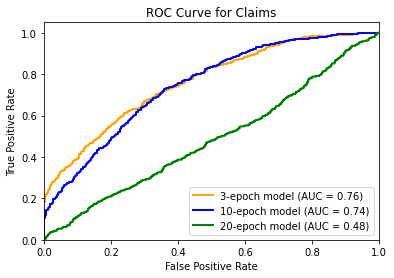

In [41]:
for i in range(len(claims_data_path)):
  lw = 2
  plt.plot(fprs[i], tprs[i], color=c[i],
          lw=lw, label=f'{epochs[i]}-epoch model (AUC = {round(roc_aucs[i], 2)})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [42]:
# ROC for patent abstracts generation
epochs = [3, 10, 20]
c = ["orange", "blue", "green"]
fprs, tprs, thresholdss = [], [], []
roc_aucs = []
for i in range(len(abstracts_data_path)):
  print(f"Load model with {epochs[i]} epochs")
  data_path = abstracts_data_path[i]
  model_path = abstracts_model_path[i]
  # load data
  train, valid, test = TabularDataset.splits(path=data_path, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)
  train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.Abstract),
                            device=device, train=True, sort=True, sort_within_batch=True)
  valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.Abstract),
                              device=device, train=True, sort=True, sort_within_batch=True)
  test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)


  best_model = BERT().to(device)

  load_checkpoint(model_path + '/model.pt', best_model)

  y_pred, test_y, y_prob = evaluate(best_model, test_iter)

  y_prob = [i[1] for i in y_prob]

  fpr, tpr, thresholds = metrics.roc_curve(test_y, y_prob, pos_label=None)
  fprs.append(fpr)
  tprs.append(tpr)
  thresholdss.append(thresholds)
  roc_auc = metrics.auc(fpr, tpr)
  roc_aucs.append(roc_auc)


  

Load model with 3 epochs


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== ./Models/Experiments/Abstracts/3epochs/BertClassifierModel/model.pt
Load model with 10 epochs


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== ./Models/Experiments/Abstracts/10epochs/BertClassifierModel/model.pt
Load model with 20 epochs


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== ./Models/Experiments/Abstracts/20epochs/BertClassifierModel/model.pt


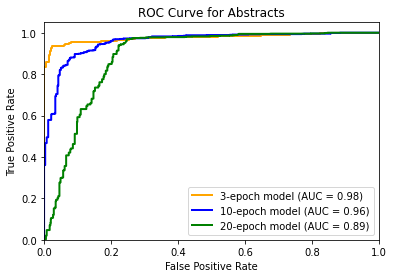

In [43]:
for i in range(len(abstracts_data_path)):
  lw = 2
  plt.plot(fprs[i], tprs[i], color=c[i],
          lw=lw, label=f'{epochs[i]}-epoch model (AUC = {round(roc_aucs[i], 2)})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()